# XGBoost (Wine) - Classification
[eXtreme Gradient Boost)](https://github.com/kyopark2014/ML-Algorithms/blob/main/boosting.md#xgboost-extreme-gradient-boost)

In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import time

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [4]:
from sklearn.model_selection import train_test_split

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [5]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [6]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [7]:
wine.isna().sum().sum()

0

In [8]:
wine['class'].value_counts()

1.0    4898
0.0    1599
Name: class, dtype: int64

### Shuffle

In [9]:
from sklearn.utils import shuffle
wine = shuffle(wine, random_state=2)

wine.head()

,alcohol,sugar,pH,class
799,10.7,3.6,3.29,0.0
1153,11.1,2.1,3.23,0.0
4915,12.0,1.1,3.16,1.0
2602,10.4,1.3,3.31,1.0
5267,11.2,11.0,3.07,1.0


In [10]:
wine['class'][1:10]

1153    0.0
4915    1.0
2602    1.0
5267    1.0
6482    1.0
5958    1.0
4862    1.0
5165    1.0
925     0.0
Name: class, dtype: float64

## Define Feature and Target

In [11]:
X = wine[['alcohol', 'sugar', 'pH']].to_numpy()
y = wine['class'].to_numpy()

## Classification Model Selection

In [46]:
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=5)

def cross_validation(model):
    start = time.time()
    
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=kfold)
    # scores = cross_val_score(model, X, y, scoring='recall', cv=kfold)
    
    print('Cross Validation:')
    print('Elased time: %0.2fs' % (time.time()-start))
    print('Accuracy:', np.round(scores, 2))
    print('Avg. Accuracy: %0.2f' % (scores.mean()))

In [47]:
cross_validation(XGBClassifier(booster='gbtree'))  # default

Cross Validation:
Elased time: 2.75s
Accuracy: [0.88 0.88 0.89 0.88 0.88]
Avg. Accuracy: 0.88


In [48]:
cross_validation(XGBClassifier(booster='gblinear'))

Cross Validation:
Elased time: 1.69s
Accuracy: [0.74 0.74 0.75 0.75 0.74]
Avg. Accuracy: 0.74


In [49]:
cross_validation(XGBClassifier(booster='dart', one_drop=1))

Cross Validation:
Elased time: 5.74s
Accuracy: [0.87 0.88 0.9  0.88 0.88]
Avg. Accuracy: 0.88


In [50]:
from sklearn.ensemble import RandomForestClassifier

cross_validation(RandomForestClassifier())

Cross Validation:
Elased time: 1.65s
Accuracy: [0.88 0.89 0.92 0.89 0.91]
Avg. Accuracy: 0.90


## HPO

### Default

In [51]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Split train/test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# define model
model = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

# default model accuacry 
def getAccuracy(model):
    start = time.time()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    default_score = accuracy_score(y_pred, y_test)

    print('Elapsed time: %0.2fs' % (time.time()-start))    
    print('default score: %0.2f' % (default_score))

getAccuracy(model)

Elapsed time: 0.55s
default score: 0.88


## HPO: Randomized Search

In [19]:
from sklearn.model_selection import RandomizedSearchCV

def randomized_search(params, runs=20): 
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)
    #xgb = XGBClassifier(booster='gblinear', objective='multi:softprob', 
    #                    random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    rand_clf = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=runs, n_jobs=-1, random_state=2, scoring='accuracy')
    
    rand_clf.fit(X_train, y_train)    
    
    best_model = rand_clf.best_estimator_    
    
    best_params = rand_clf.best_params_
    print("best parameter:", best_params)
    
    best_score = rand_clf.best_score_
    print("best score: {:.3f}".format(best_score))
    
    return best_model

In [20]:
import time
start = time.time()

best_model = randomized_search(
    params={
        'n_estimators':[50, 100, 200],
        'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        'max_depth':[1, 2, 3, 5, 6, 8],
        'gamma':[0, 0.01, 0.1, 0.5, 1, 2],
        'min_child_weight':[1, 2, 3, 4, 5],
        'subsample':[0.5, 0.7, 0.8, 0.9, 1],
        'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1],  
        }, 
    runs=20)

print('\nElased time: %0.2fs' % (time.time()-start))

best parameter: {'subsample': 1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.4, 'gamma': 0.5, 'colsample_bytree': 0.7}
best score: 0.871

Elased time: 7.15s


In [21]:
best_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0.5,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.4,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 8,
 'max_leaves': 0,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 200,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 2,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0}

## Evaluation

In [52]:
model = best_model

def model_estimation(model):    
    y_pred = model.predict(X_test)

    from sklearn.metrics import confusion_matrix
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

    from sklearn.metrics import classification_report
    print('\nClassification Report:')
    print(classification_report(y_true=y_test, y_pred = y_pred))

    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
    print('Accuracy Score: %0.2f' % (accuracy_score(y_test,y_pred)))
    print('Precision Score: %0.2f' % (precision_score(y_test,y_pred)))
    print('Recall Score: %0.2f' % (recall_score(y_test,y_pred)))
    print('F1 Score: %0.2f' % (f1_score(y_test,y_pred)))

cross_validation(model)   
model_estimation(model)    

Cross Validation:
Elased time: 5.55s
Accuracy: [0.87 0.88 0.89 0.88 0.88]
Avg. Accuracy: 0.88

Confusion Matrix:
[[ 286   98]
 [  91 1150]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75       384
         1.0       0.92      0.93      0.92      1241

    accuracy                           0.88      1625
   macro avg       0.84      0.84      0.84      1625
weighted avg       0.88      0.88      0.88      1625

Accuracy Score: 0.88
Precision Score: 0.92
Recall Score: 0.93
F1 Score: 0.92


## Feature Importances

Feature Importances:
[0.19435309 0.6095557  0.19609122]
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


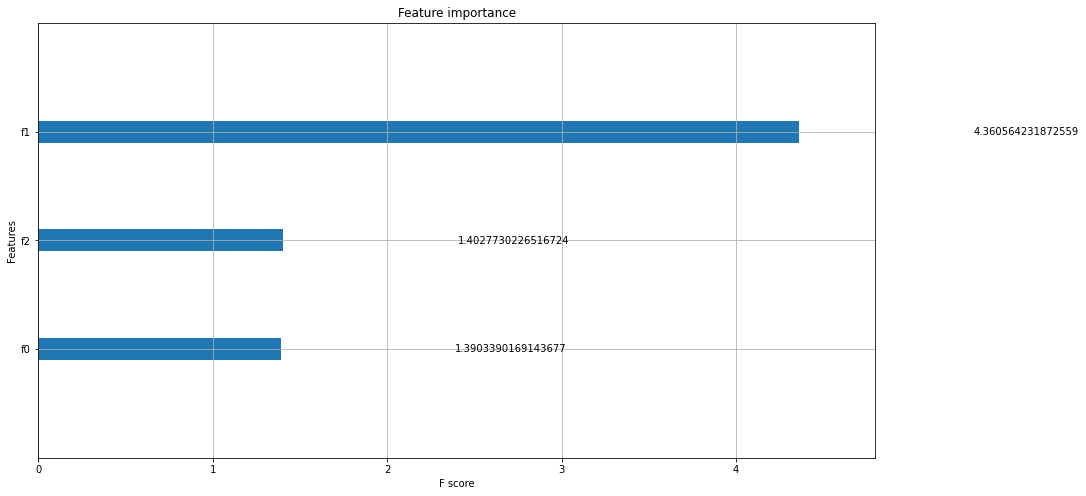

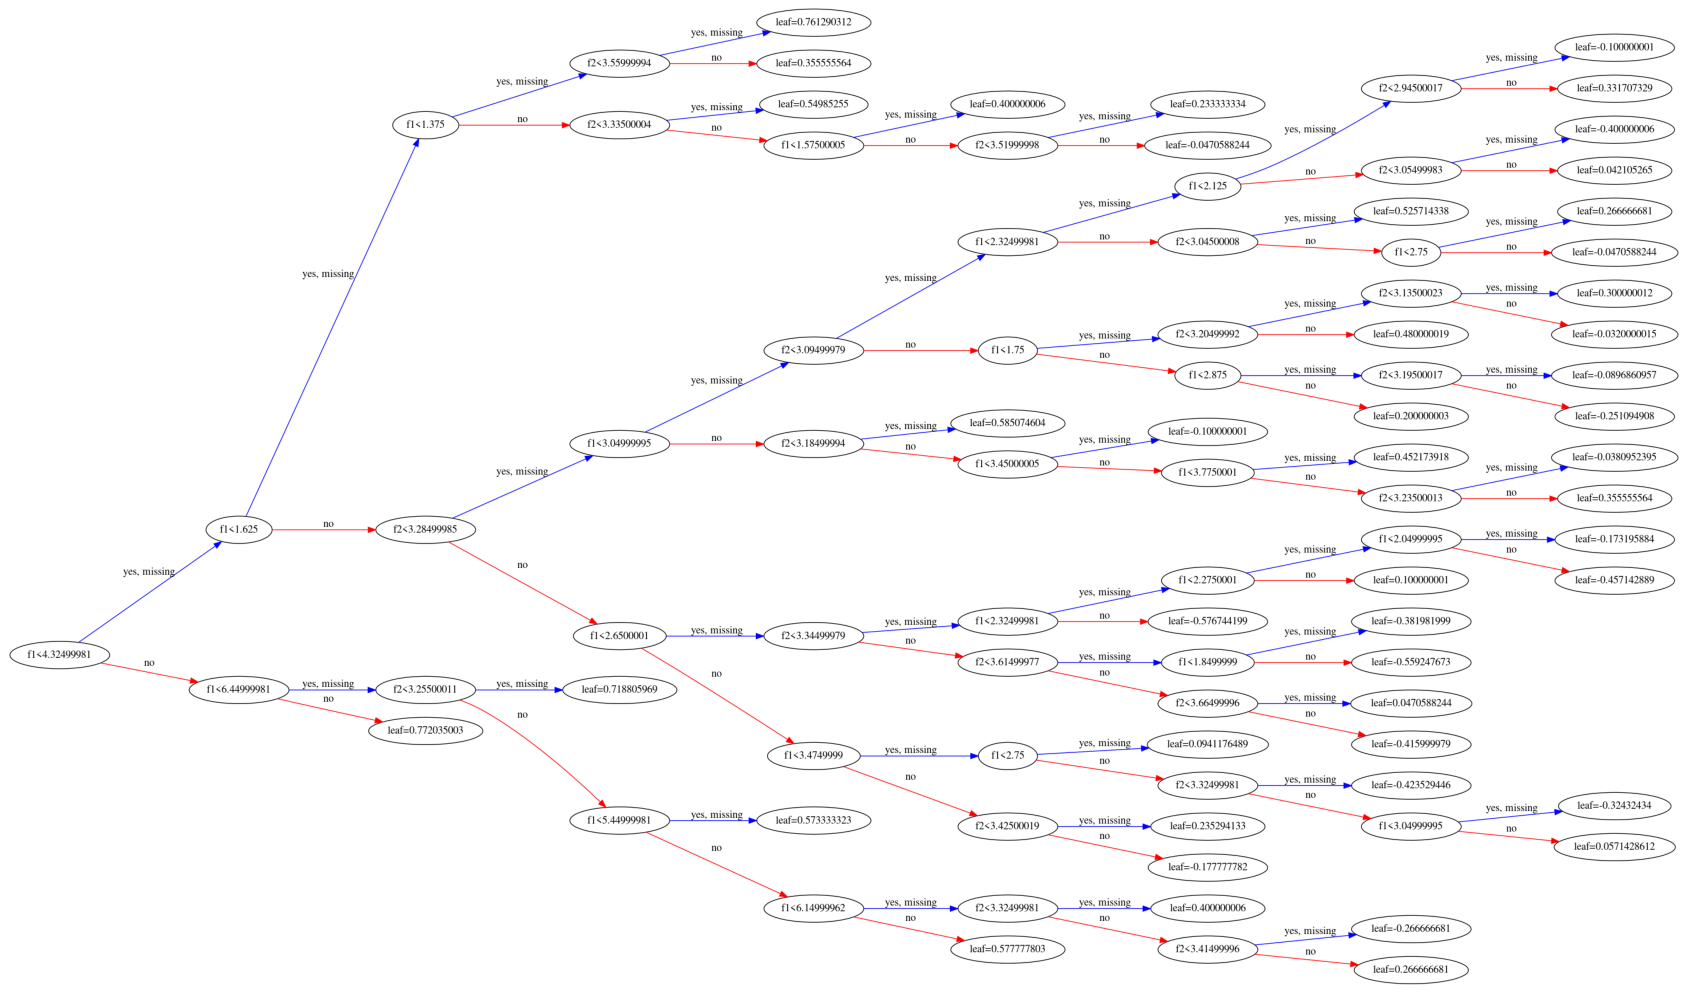

In [56]:
print('Feature Importances:')
print(model.feature_importances_)

import xgboost as xgb

feature_data = xgb.DMatrix(X_test)
model.get_booster().feature_names = feature_data.feature_names
model.get_booster().feature_types = feature_data.feature_types

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(model, ax=ax, importance_type='gain')

!pip install graphviz

xgb.plot_tree(model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(30, 20)
plt.show()